# **WHAT IS THE NCAA?**
The National Collegiate Athletic Association is a member-led organization dedicated to the well-being and lifelong success of college athletes.
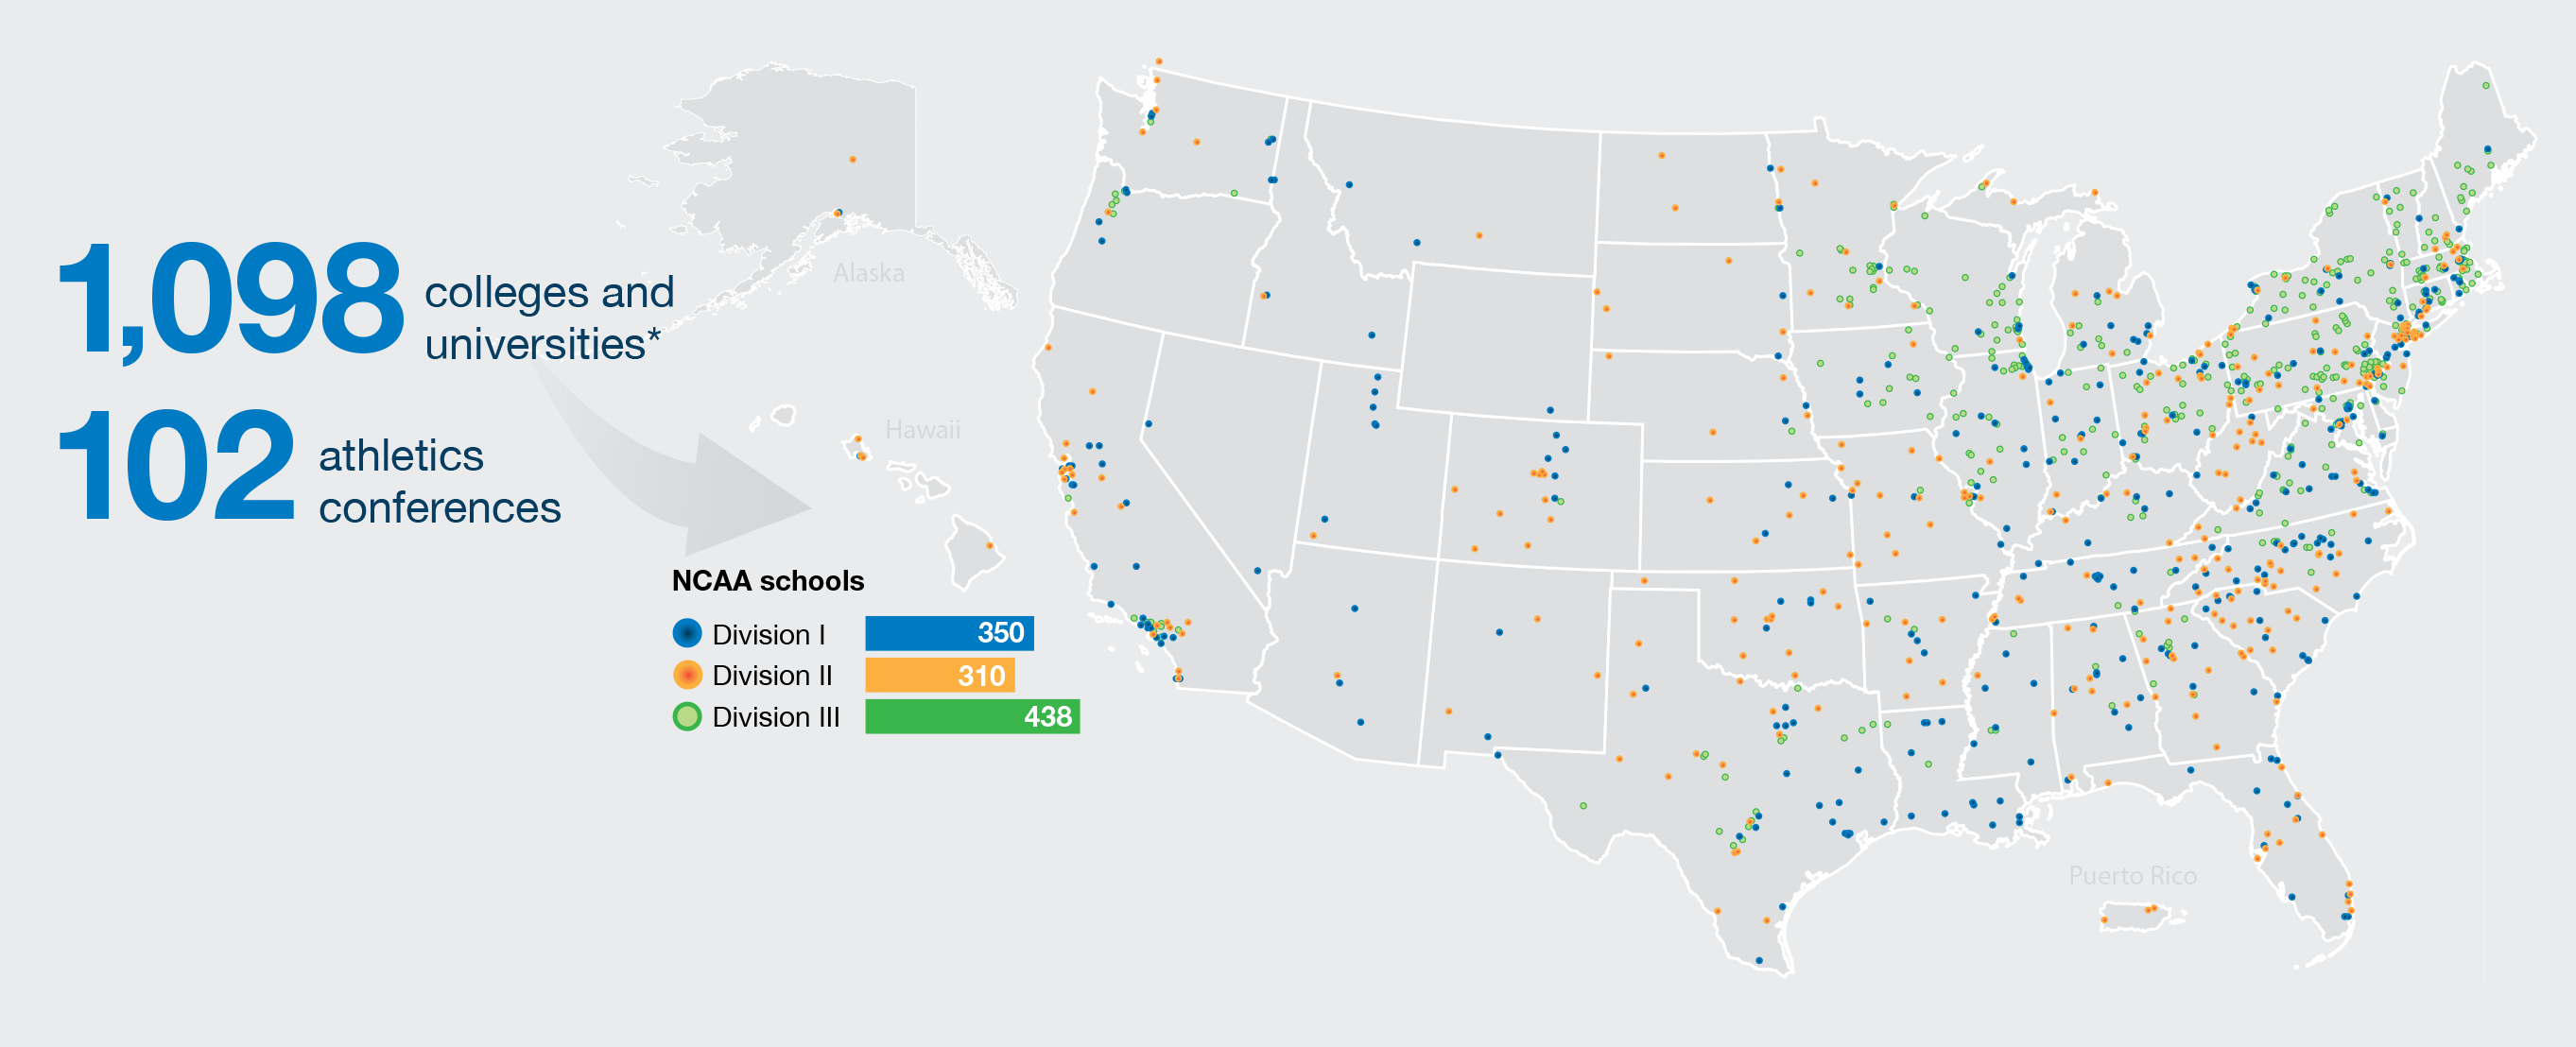![](http://)

# **About March Madness**
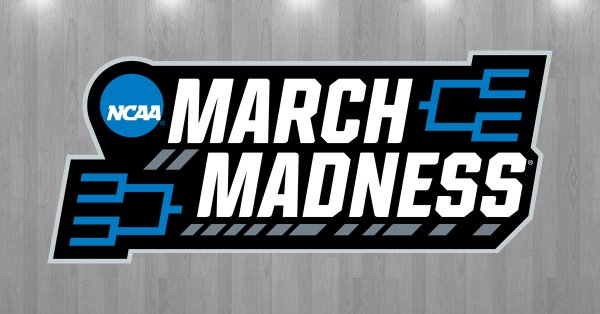

March Madness is a popular on-ending basketball tournaments played in March. March Madness is also a registered trademark currently owned exclusively by the NCAA.

# Preparation

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold
import matplotlib.ticker as ticker
import matplotlib.animation as animation
from IPython.display import HTML
import random
import matplotlib as mpl
from matplotlib.patches import Circle, Rectangle, Arc
import seaborn as sns
plt.style.use('seaborn-dark-palette')
mypal = plt.rcParams['axes.prop_cycle'].by_key()['color'] # Grab the color pal

import os
import gc

MENS_DIR = '../input/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament'

# Feature engineering

My work is fundamentally inherited from [Pentagram](https://www.kaggle.com/nxrprime) 's great work. By the way, I've added some changes

In [ ]:
result = pd.read_csv('../input/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament/MDataFiles_Stage1/MNCAATourneyCompactResults.csv')
result = result.drop(columns=['WLoc', 'NumOT', 'DayNum'])
result.head()

In [ ]:
seeds = pd.read_csv('../input/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament/MDataFiles_Stage1/MNCAATourneySeeds.csv')
seeds.Seed = seeds.Seed.map(lambda string : int(string[1:3]))
seeds.head()

In [ ]:
team_name = pd.read_csv('../input/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament/MDataFiles_Stage1/MTeamSpellings.csv',
                       encoding='cp1252')
team_name = team_name.drop_duplicates(subset=['TeamID'], keep='last').reset_index(drop=True)
team_name.TeamNameSpelling = team_name.TeamNameSpelling.map(lambda string : string.upper())
team_name.head()

In [ ]:
teams_avg_seed = seeds.groupby('TeamID').Seed.mean().sort_values()
low_seed = pd.merge(left=teams_avg_seed, right=team_name, how='left', on=['TeamID'] ).head(20)
plt.figure(figsize=(20,10))
ax = sns.barplot(low_seed.Seed, low_seed.TeamNameSpelling)
plt.title('Top 20 rich-traditional NCAA Teams')
for p in ax.patches:
    plt.text(p.get_width()-0.07, 
    p.get_y()+0.55*p.get_height(),f'{p.get_width():.2f}',ha='center', va='center')

#### The 2 most prestigious and rich-traditional teams are Duke and Kansas Jayhawks. I had predicted that before I entered this compettion because Blue Devils won 5 NCAA Championships (fourth all-time) and has an NCAA-best 75,5% NCAA tournament winning percentage. And  other one is currently all-time consecutive conference titles record holder with 14 consecutive titles (2005-2018), also has 5 overall claimed National Championships

![maxresdefault](https://user-images.githubusercontent.com/52401767/74656114-1cfaf180-51c0-11ea-9fb1-b5a73955ad91.jpg)


#### List of NCAA  basketball champions in the period of 1985-2019

In [ ]:
Wname = team_name.rename(columns={'TeamNameSpelling':'Wteam_name', 'TeamID':'WTeamID'})
team_result = pd.merge(left=result, right=Wname, how='left', on=['WTeamID'])

win_by_year = team_result.groupby(['Season', 'Wteam_name'])\
              ['WScore'].count().reset_index()\
              .rename(columns={'Wteam_name':'Team', 'WScore':'Win_matches'})
              
df = win_by_year[win_by_year.Win_matches == win_by_year.Win_matches.max()].drop(columns=['Win_matches']).set_index('Season')
df

In [ ]:
plt.figure(figsize=(22,8))
ax = sns.countplot(df.Team)
for p in ax.patches:
    ax.text(p.get_x()+p.get_width()/2., p.get_height()+0.05, f'{p.get_height()}',ha='center')
plt.title('Most successful colleges in the NCAA Tournament')
plt.ylabel('Number of NCAA titles')

### Creat a bar chart race to have a greater insight into these basketball team's performance

Pause button is on the middle

[Reference](https://towardsdatascience.com/bar-chart-race-in-python-with-matplotlib-8e687a5c8a41)

In [ ]:
win_by_year = win_by_year.groupby(['Team', 'Season']).Win_matches.sum()\
              .unstack(fill_value=0).cumsum(axis=1).sort_values(by=2019, ascending=False).head(15)
cum_win = pd.melt(win_by_year, value_vars=win_by_year.columns, value_name="Win_matches")
cum_win['Team'] = list(win_by_year.index)*35
cum_win = cum_win[['Season', 'Team', 'Win_matches']]

In [ ]:
fig, ax = plt.subplots(figsize=(15, 8))

colors = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(15)]
team2color = dict(zip(cum_win.Team, colors))

def draw_barchart(current_season):
    dff = cum_win[cum_win['Season'].eq(current_season)].sort_values(by='Win_matches', ascending=True)
    ax.clear()
    ax.barh(dff['Team'], dff['Win_matches'], color=dff['Team'].map(team2color))
    dx = dff['Win_matches'].max() / 200
    for i, (value, name) in enumerate(zip(dff['Win_matches'], dff['Team'])):
        ax.text(value-dx, i,     name,       size=10, weight=600, ha='right', va='bottom')
        ax.text(value+dx, i,     f'{value:}',size=10, ha='left',  va='center')
        
    ax.text(1, 0.4, current_season, transform=ax.transAxes, color='#777777', size=46, ha='right', weight=800)
    ax.text(0, 1.06, 'Matches', transform=ax.transAxes, size=12, color='#777777')
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    ax.xaxis.set_ticks_position('top')
    ax.tick_params(axis='x', colors='#777777', labelsize=12)
    ax.set_yticks([])
    ax.margins(0, 0.01)
    ax.grid(which='major', axis='x', linestyle='-')
    ax.set_axisbelow(True)
    ax.text(0, 1.15, 'Number of win matches of top 15 NCAA teams from 1985 to 2019',
            transform=ax.transAxes, size=24, weight=600, ha='left', va='top')
    plt.box(False)
    
animator = animation.FuncAnimation(fig, draw_barchart, frames=range(1985, 2020),repeat=True, interval=500)
HTML(animator.to_jshtml())

## Merge seeds

In [ ]:
Wseeds = seeds.rename(columns={'TeamID':'WTeamID', 'Seed':'WSeed'})
Lseeds = seeds.rename(columns={'TeamID':'LTeamID', 'Seed':'LSeed'})

data = pd.merge(left=result, right=Wseeds, how='left', on=['Season', 'WTeamID'])
data = pd.merge(left=data, right=Lseeds, on=['Season', 'LTeamID'])

data.head()

In [ ]:
low_seed_win = data[data.WSeed < data.LSeed].groupby('Season')['WSeed'].count()
high_seed_win = data[data.WSeed > data.LSeed].groupby('Season')['WSeed'].count()

plt.figure(figsize=(20,10))
N = len(low_seed_win)
low_seed_win_std = low_seed_win - low_seed_win.mean()
high_seed_win_std = high_seed_win - high_seed_win.mean()

ind = np.arange(N)   
width = 0.35       

p1 = plt.bar(ind, low_seed_win, width, yerr=low_seed_win_std)
p2 = plt.bar(ind, high_seed_win, width,
             bottom=low_seed_win, yerr=high_seed_win_std)
p3 = plt.plot(np.arange(-1,N+1), [low_seed_win.mean()]*(N+2), linestyle='--', color='yellow')
plt.ylabel('Number of matches')
plt.title('Winning ratio over years')
plt.xticks(ind, low_seed_win.index)
plt.yticks(np.arange(0, 81, 10))

plt.legend((p1[0], p2[0], p3[0]), ('Low seed wins', 'High seed wins', f'Average : {low_seed_win.mean():.2f} (matches)'))

plt.show()

#### On average, a team with higher seed has up to 44.6% chance to beat higher-appreciated opponent. This is easy to understand and trivially happened in history . As the case of Loyola Marymount on 1990, they are 11st seed that year but the Lion was a blast to watch. They scored averaged 122.4 points per game, which will be discussed below on NCAA's records section 🌟🌟

In [ ]:
scores = pd.read_csv('../input/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament/MDataFiles_Stage1/MRegularSeasonCompactResults.csv')
scores.head()

In [ ]:
Lscores = scores[['Season', 'WTeamID', 'WScore']].rename(columns={'WTeamID':'TeamID', 'WScore':'Score'})
Wscores = scores[['Season', 'LTeamID', 'LScore']].rename(columns={'LTeamID':'TeamID', 'LScore':'Score'})

result_scores = pd.concat([Wscores, Lscores])
result_scores.head()

In [ ]:
season_score = result_scores.groupby(['Season', 'TeamID'])['Score'].sum()
season_score.sort_values(ascending=False).head()

In [ ]:
result_scores.sort_values(by='Score', ascending=False).head(15)

### It seems that somehow, The 1258 and 1328 team were involved in all four of the highest scoring games, nine of the top 16 and four of 5 highest all season scoring .  Who are they?

In [ ]:
team_name[team_name.TeamID.isin([1258, 1328])]

### Loyola Marymount Lions and Oklahoma Sooners

In 1991, when two of the top four highest-scoring NCAAT games were recorded, the Lions' scored 186 points on a crazy match — 15 more than the next highest team - the Sooner. But on the previous year, Oklahoma scored 7 more points on a single match compares to Loyola Marymount. They are actually rivals on that time the Lions were masters of getting other teams to play at their pace and the Sooner even beat Kansas beaten twice in regular season play.


![sportfximg-119214-10809-1psbkb q8y0g](https://user-images.githubusercontent.com/52401767/74666274-ca2b3500-51d3-11ea-9939-d5efe3a25370.jpg)


## Merge score

In [ ]:
data = pd.merge(data, season_score, left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID'], how='left')
data = data.rename(columns={'Score':'WScoreT'})
data = pd.merge(data, season_score, left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID'], how='left')
data = data.rename(columns={'Score':'LScoreT'})
data = data.drop(columns=['WScore', 'LScore'])
data.head()

In [ ]:
low_score_win = data[data.WScoreT < data.LScoreT].groupby('Season')['WSeed'].count()
high_score_win = data[data.WScoreT > data.LScoreT].groupby('Season')['WSeed'].count()

plt.figure(figsize=(20,10))
N = len(low_score_win)
low_score_win_std = low_score_win - low_score_win.mean()
high_score_win_std = high_score_win - high_score_win.mean()

ind = np.arange(N)   
width = 0.35       

p1 = plt.bar(ind, low_score_win, width, yerr=low_score_win_std)
p2 = plt.bar(ind, high_score_win, width,
             bottom=low_score_win, yerr=high_score_win_std)
p3 = plt.plot(np.arange(-1,N+1), [low_score_win.mean()]*(N+2), linestyle='--', color='yellow')
plt.ylabel('Number of matches')
plt.title('Winning ratio over years')
plt.xticks(ind, low_score_win.index)
plt.yticks(np.arange(0, 81, 10))
plt.legend((p1[0], p2[0], p3[0]), ('Low score wins', 'High score wins', f'Average : {low_score_win.mean():.2f} (matches)'))

plt.show()

#### On average, a team with lower score has about 24% chance to win against their opponent

In [ ]:
Mss = pd.read_csv(f'{MENS_DIR}/MSampleSubmissionStage1_2020.csv')

In [ ]:
mens_events = []
for year in [2015, 2016, 2017, 2018, 2019]:
    mens_events.append(pd.read_csv(f'{MENS_DIR}/MEvents{year}.csv'))
MEvents = pd.concat(mens_events)
print(MEvents.shape)
MEvents.head()

In [ ]:
# Event Types
plt.style.use('fivethirtyeight')
MEvents['counter'] = 1
MEvents.groupby('EventType')['counter'] \
    .sum() \
    .sort_values(ascending=False) \
    .plot(kind='bar',
          figsize=(15, 5),
         color=mypal[2],
         title='Event Type Frequency (Mens)')
plt.xticks(rotation=0)
plt.show()

In [ ]:
area_mapping = {0: np.nan,
                1: 'under basket',
                2: 'in the paint',
                3: 'inside right wing',
                4: 'inside right',
                5: 'inside center',
                6: 'inside left',
                7: 'inside left wing',
                8: 'outside right wing',
                9: 'outside right',
                10: 'outside center',
                11: 'outside left',
                12: 'outside left wing',
                13: 'backcourt'}

MEvents['Area_Name'] = MEvents['Area'].map(area_mapping)

In [ ]:
MEvents.groupby('Area_Name')['counter'].sum() \
    .sort_values() \
    .plot(kind='barh',
          figsize=(15, 8),
          title='Frequency of Event Area')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(15, 8))
for i, d in MEvents.loc[~MEvents['Area_Name'].isna()].groupby('Area_Name'):
    d.plot(x='X', y='Y', style='.', label=i, ax=ax, title='Visualizing Event Areas')
    ax.legend()
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)
plt.show()

In [ ]:
# Normalize X, Y positions for court dimentions
# Court is 50 feet wide and 94 feet end to end.
MEvents['X_'] = (MEvents['X'] * (94/100))
MEvents['Y_'] = (MEvents['Y'] * (50/100))

In [ ]:
def create_ncaa_full_court(ax=None, three_line='mens', court_color='#dfbb85',
                           lw=3, lines_color='black', lines_alpha=0.5,
                           paint_fill='blue', paint_alpha=0.4,
                           inner_arc=False):
    """
    Version 2020.2.19
    Creates NCAA Basketball Court
    Dimensions are in feet (Court is 97x50 ft)
    Created by: Rob Mulla / https://github.com/RobMulla

    * Note that this function uses "feet" as the unit of measure.
    * NCAA Data is provided on a x range: 0, 100 and y-range 0 to 100
    * To plot X/Y positions first convert to feet like this:
    ```
    Events['X_'] = (Events['X'] * (94/100))
    Events['Y_'] = (Events['Y'] * (50/100))
    ```
    
    ax: matplotlib axes if None gets current axes using `plt.gca`


    three_line: 'mens', 'womens' or 'both' defines 3 point line plotted
    court_color : (hex) Color of the court
    lw : line width
    lines_color : Color of the lines
    lines_alpha : transparency of lines
    paint_fill : Color inside the paint
    paint_alpha : transparency of the "paint"
    inner_arc : paint the dotted inner arc
    """
    if ax is None:
        ax = plt.gca()

    # Create Pathes for Court Lines
    center_circle = Circle((94/2, 50/2), 6,
                           linewidth=lw, color=lines_color, lw=lw,
                           fill=False, alpha=lines_alpha)
    hoop_left = Circle((5.25, 50/2), 1.5 / 2,
                       linewidth=lw, color=lines_color, lw=lw,
                       fill=False, alpha=lines_alpha)
    hoop_right = Circle((94-5.25, 50/2), 1.5 / 2,
                        linewidth=lw, color=lines_color, lw=lw,
                        fill=False, alpha=lines_alpha)

    # Paint - 18 Feet 10 inches which converts to 18.833333 feet - gross!
    left_paint = Rectangle((0, (50/2)-6), 18.833333, 12,
                           fill=paint_fill, alpha=paint_alpha,
                           lw=lw, edgecolor=None)
    right_paint = Rectangle((94-18.83333, (50/2)-6), 18.833333,
                            12, fill=paint_fill, alpha=paint_alpha,
                            lw=lw, edgecolor=None)
    
    left_paint_boarder = Rectangle((0, (50/2)-6), 18.833333, 12,
                           fill=False, alpha=lines_alpha,
                           lw=lw, edgecolor=lines_color)
    right_paint_boarder = Rectangle((94-18.83333, (50/2)-6), 18.833333,
                            12, fill=False, alpha=lines_alpha,
                            lw=lw, edgecolor=lines_color)

    left_arc = Arc((18.833333, 50/2), 12, 12, theta1=-
                   90, theta2=90, color=lines_color, lw=lw,
                   alpha=lines_alpha)
    right_arc = Arc((94-18.833333, 50/2), 12, 12, theta1=90,
                    theta2=-90, color=lines_color, lw=lw,
                    alpha=lines_alpha)
    
    leftblock1 = Rectangle((7, (50/2)-6-0.666), 1, 0.666,
                           fill=True, alpha=lines_alpha,
                           lw=0, edgecolor=lines_color,
                           facecolor=lines_color)
    leftblock2 = Rectangle((7, (50/2)+6), 1, 0.666,
                           fill=True, alpha=lines_alpha,
                           lw=0, edgecolor=lines_color,
                           facecolor=lines_color)
    ax.add_patch(leftblock1)
    ax.add_patch(leftblock2)
    
    left_l1 = Rectangle((11, (50/2)-6-0.666), 0.166, 0.666,
                           fill=True, alpha=lines_alpha,
                           lw=0, edgecolor=lines_color,
                           facecolor=lines_color)
    left_l2 = Rectangle((14, (50/2)-6-0.666), 0.166, 0.666,
                           fill=True, alpha=lines_alpha,
                           lw=0, edgecolor=lines_color,
                           facecolor=lines_color)
    left_l3 = Rectangle((17, (50/2)-6-0.666), 0.166, 0.666,
                           fill=True, alpha=lines_alpha,
                           lw=0, edgecolor=lines_color,
                           facecolor=lines_color)
    ax.add_patch(left_l1)
    ax.add_patch(left_l2)
    ax.add_patch(left_l3)
    left_l4 = Rectangle((11, (50/2)+6), 0.166, 0.666,
                           fill=True, alpha=lines_alpha,
                           lw=0, edgecolor=lines_color,
                           facecolor=lines_color)
    left_l5 = Rectangle((14, (50/2)+6), 0.166, 0.666,
                           fill=True, alpha=lines_alpha,
                           lw=0, edgecolor=lines_color,
                           facecolor=lines_color)
    left_l6 = Rectangle((17, (50/2)+6), 0.166, 0.666,
                           fill=True, alpha=lines_alpha,
                           lw=0, edgecolor=lines_color,
                           facecolor=lines_color)
    ax.add_patch(left_l4)
    ax.add_patch(left_l5)
    ax.add_patch(left_l6)
    
    rightblock1 = Rectangle((94-7-1, (50/2)-6-0.666), 1, 0.666,
                           fill=True, alpha=lines_alpha,
                           lw=0, edgecolor=lines_color,
                           facecolor=lines_color)
    rightblock2 = Rectangle((94-7-1, (50/2)+6), 1, 0.666,
                           fill=True, alpha=lines_alpha,
                           lw=0, edgecolor=lines_color,
                           facecolor=lines_color)
    ax.add_patch(rightblock1)
    ax.add_patch(rightblock2)

    right_l1 = Rectangle((94-11, (50/2)-6-0.666), 0.166, 0.666,
                           fill=True, alpha=lines_alpha,
                           lw=0, edgecolor=lines_color,
                           facecolor=lines_color)
    right_l2 = Rectangle((94-14, (50/2)-6-0.666), 0.166, 0.666,
                           fill=True, alpha=lines_alpha,
                           lw=0, edgecolor=lines_color,
                           facecolor=lines_color)
    right_l3 = Rectangle((94-17, (50/2)-6-0.666), 0.166, 0.666,
                           fill=True, alpha=lines_alpha,
                           lw=0, edgecolor=lines_color,
                           facecolor=lines_color)
    ax.add_patch(right_l1)
    ax.add_patch(right_l2)
    ax.add_patch(right_l3)
    right_l4 = Rectangle((94-11, (50/2)+6), 0.166, 0.666,
                           fill=True, alpha=lines_alpha,
                           lw=0, edgecolor=lines_color,
                           facecolor=lines_color)
    right_l5 = Rectangle((94-14, (50/2)+6), 0.166, 0.666,
                           fill=True, alpha=lines_alpha,
                           lw=0, edgecolor=lines_color,
                           facecolor=lines_color)
    right_l6 = Rectangle((94-17, (50/2)+6), 0.166, 0.666,
                           fill=True, alpha=lines_alpha,
                           lw=0, edgecolor=lines_color,
                           facecolor=lines_color)
    ax.add_patch(right_l4)
    ax.add_patch(right_l5)
    ax.add_patch(right_l6)
    
    # 3 Point Line
    if (three_line == 'mens') | (three_line == 'both'):
        # 22' 1.75" distance to center of hoop
        three_pt_left = Arc((6.25, 50/2), 44.291, 44.291, theta1=-78,
                            theta2=78, color=lines_color, lw=lw,
                            alpha=lines_alpha)
        three_pt_right = Arc((94-6.25, 50/2), 44.291, 44.291,
                             theta1=180-78, theta2=180+78,
                             color=lines_color, lw=lw, alpha=lines_alpha)

        # 4.25 feet max to sideline for mens
        ax.plot((0, 11.25), (3.34, 3.34),
                color=lines_color, lw=lw, alpha=lines_alpha)
        ax.plot((0, 11.25), (50-3.34, 50-3.34),
                color=lines_color, lw=lw, alpha=lines_alpha)
        ax.plot((94-11.25, 94), (3.34, 3.34),
                color=lines_color, lw=lw, alpha=lines_alpha)
        ax.plot((94-11.25, 94), (50-3.34, 50-3.34),
                color=lines_color, lw=lw, alpha=lines_alpha)
        ax.add_patch(three_pt_left)
        ax.add_patch(three_pt_right)

    if (three_line == 'womens') | (three_line == 'both'):
        # womens 3
        three_pt_left_w = Arc((6.25, 50/2), 20.75 * 2, 20.75 * 2, theta1=-85,
                              theta2=85, color=lines_color, lw=lw, alpha=lines_alpha)
        three_pt_right_w = Arc((94-6.25, 50/2), 20.75 * 2, 20.75 * 2,
                               theta1=180-85, theta2=180+85,
                               color=lines_color, lw=lw, alpha=lines_alpha)

        # 4.25 inches max to sideline for mens
        ax.plot((0, 8.3), (4.25, 4.25), color=lines_color,
                lw=lw, alpha=lines_alpha)
        ax.plot((0, 8.3), (50-4.25, 50-4.25),
                color=lines_color, lw=lw, alpha=lines_alpha)
        ax.plot((94-8.3, 94), (4.25, 4.25),
                color=lines_color, lw=lw, alpha=lines_alpha)
        ax.plot((94-8.3, 94), (50-4.25, 50-4.25),
                color=lines_color, lw=lw, alpha=lines_alpha)

        ax.add_patch(three_pt_left_w)
        ax.add_patch(three_pt_right_w)

    # Add Patches
    ax.add_patch(left_paint)
    ax.add_patch(left_paint_boarder)
    ax.add_patch(right_paint)
    ax.add_patch(right_paint_boarder)
    ax.add_patch(center_circle)
    ax.add_patch(hoop_left)
    ax.add_patch(hoop_right)
    ax.add_patch(left_arc)
    ax.add_patch(right_arc)
    
    if inner_arc:
        left_inner_arc = Arc((18.833333, 50/2), 12, 12, theta1=90,
                             theta2=-90, color=lines_color, lw=lw,
                       alpha=lines_alpha, ls='--')
        right_inner_arc = Arc((94-18.833333, 50/2), 12, 12, theta1=-90,
                        theta2=90, color=lines_color, lw=lw,
                        alpha=lines_alpha, ls='--')
        ax.add_patch(left_inner_arc)
        ax.add_patch(right_inner_arc)

    # Restricted Area Marker
    restricted_left = Arc((6.25, 50/2), 8, 8, theta1=-90,
                        theta2=90, color=lines_color, lw=lw,
                        alpha=lines_alpha)
    restricted_right = Arc((94-6.25, 50/2), 8, 8,
                         theta1=180-90, theta2=180+90,
                         color=lines_color, lw=lw, alpha=lines_alpha)
    ax.add_patch(restricted_left)
    ax.add_patch(restricted_right)
    
    # Backboards
    ax.plot((4, 4), ((50/2) - 3, (50/2) + 3),
            color=lines_color, lw=lw*1.5, alpha=lines_alpha)
    ax.plot((94-4, 94-4), ((50/2) - 3, (50/2) + 3),
            color=lines_color, lw=lw*1.5, alpha=lines_alpha)
    ax.plot((4, 4.6), (50/2, 50/2), color=lines_color,
            lw=lw, alpha=lines_alpha)
    ax.plot((94-4, 94-4.6), (50/2, 50/2),
            color=lines_color, lw=lw, alpha=lines_alpha)

    # Half Court Line
    ax.axvline(94/2, color=lines_color, lw=lw, alpha=lines_alpha)

    # Boarder
    boarder = Rectangle((0.3,0.3), 94-0.4, 50-0.4, fill=False, lw=3, color='black', alpha=lines_alpha)
    ax.add_patch(boarder)
    
    # Plot Limit
    ax.set_xlim(0, 94)
    ax.set_ylim(0, 50)
    ax.set_facecolor(court_color)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    return ax


fig, ax = plt.subplots(figsize=(15, 8.5))
create_ncaa_full_court(ax, three_line='both', paint_alpha=0.4)
plt.show()


In [ ]:
fig, ax = plt.subplots(figsize=(15, 7.8))
ms = 10
ax = create_ncaa_full_court(ax, paint_alpha=0.1)
MEvents.query('EventType == "turnover"') \
    .plot(x='X_', y='Y_', style='X',
          title='Turnover Locations (Mens)',
          c='red',
          alpha=0.3,
         figsize=(15, 9),
         label='Steals',
         ms=ms,
         ax=ax)
ax.set_xlabel('')
ax.get_legend().remove()
plt.show()

In [ ]:
MPlayers = pd.read_csv(f'{MENS_DIR}/MPlayers.csv', error_bad_lines=False)

In [ ]:
MPlayers.head()

In [ ]:
MPlayers[(MPlayers['LastName']=='Williamson')&(MPlayers['FirstName']=='Zion')]

In [ ]:
MPlayers[MPlayers['LastName']=='Ayton']

In [ ]:
MPlayers[(MPlayers['LastName']=='Simmons')&(MPlayers['FirstName']=='Ben')]

In [ ]:
# Merge Player name onto events
MEvents = MEvents.merge(MPlayers,
              how='left',
              left_on='EventPlayerID',
              right_on='PlayerID')


In [ ]:
MEvents.loc[MEvents['PlayerID'] == 2825].groupby('EventType')['EventID'].count() \
    .sort_values() \
    .plot(kind='barh',
          figsize=(15, 5),
          title='Zion Williamson event type count',
          color=mypal[1])
plt.show()

In [ ]:
MEvents.loc[MEvents['PlayerID'] == 400].groupby('EventType')['EventID'].count() \
    .sort_values() \
    .plot(kind='barh',
          figsize=(15, 5),
          title='Deandre Ayton event type count',
          color=mypal[1])
plt.show()

In [ ]:
MEvents.loc[MEvents['PlayerID'] == 5829].groupby('EventType')['EventID'].count() \
    .sort_values() \
    .plot(kind='barh',
          figsize=(15, 5),
          title='Ben Simmons event type count',
          color=mypal[1])
plt.show()

In [ ]:
ms = 10 # Marker Size
FirstName = 'Zion'
LastName = 'Williamson'
fig, ax = plt.subplots(figsize=(15, 8))
ax = create_ncaa_full_court(ax)
MEvents.query('FirstName == @FirstName and LastName == @LastName and EventType == "made2"') \
    .plot(x='X_', y='Y_', style='o',
          title='Shots (Zion Williamson)',
          alpha=0.5,
         figsize=(15, 8),
         label='Made 2',
         ms=ms,
         ax=ax)
plt.legend()
MEvents.query('FirstName == @FirstName and LastName == @LastName and EventType == "miss2"') \
    .plot(x='X_', y='Y_', style='X',
          alpha=0.5, ax=ax,
         label='Missed 2',
         ms=ms)
plt.legend()
MEvents.query('FirstName == @FirstName and LastName == @LastName and EventType == "made3"') \
    .plot(x='X_', y='Y_', style='o',
          c='brown',
          alpha=0.5,
         figsize=(15, 8),
         label='Made 3', ax=ax,
         ms=ms)
plt.legend()
MEvents.query('FirstName == @FirstName and LastName == @LastName and EventType == "miss3"') \
    .plot(x='X_', y='Y_', style='X',
          c='green',
          alpha=0.5, ax=ax,
         label='Missed 3',
         ms=ms)
ax.set_xlabel('')
plt.legend()
plt.show()

# **Shot Heatmap**

In [ ]:
N_bins = 100
shot_events = MEvents.loc[MEvents['EventType'].isin(['miss3','made3','miss2','made2']) & (MEvents['X_'] != 0)]
fig, ax = plt.subplots(figsize=(15, 7))
ax = create_ncaa_full_court(ax,
                            paint_alpha=0.0,
                            three_line='mens',
                            court_color='black',
                            lines_color='white')
_ = plt.hist2d(shot_events['X_'].values + np.random.normal(0, 0.1, shot_events['X_'].shape), # Add Jitter to values for plotting
           shot_events['Y_'].values + np.random.normal(0, 0.1, shot_events['Y_'].shape),
           bins=N_bins, norm=mpl.colors.LogNorm(),
               cmap='plasma')

# Plot a colorbar with label.
cb = plt.colorbar()
cb.set_label('Number of shots')

ax.set_title('Shot Heatmap (Mens)')
plt.show()